# Siamese Network for Signature Verification (Improved)

This notebook implements a **Siamese Network** to learn a similarity metric between signatures.
**Improvements**:
1. **Transfer Learning**: Uses `MobileNetV2` (pretrained on ImageNet) as the embedding backbone.
2. **Data Augmentation**: Applies random rotation and zoom to training pairs to improve generalization.
3. **Refined Training**: Uses `Adam` optimizer and `ReduceLROnPlateau` scheduler.

In [15]:
import os
import random
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from tensorflow.keras import backend as K

# Set Random Seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU Detected: {gpus}")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU detected. Running on CPU.")

No GPU detected. Running on CPU.


In [16]:
# Configuration
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SOURCE_DIR = "signatures"
MARGIN = 1.0 # Margin for Contrastive Loss

## 1. Data Preparation
Loading data and splitting by Person ID.

In [17]:
def load_data(source_dir):
    data = {}
    if not os.path.exists(source_dir):
        print(f"Error: Source directory '{source_dir}' not found.")
        return data

    subdirs = os.listdir(source_dir)
    for folder in subdirs:
        path = os.path.join(source_dir, folder)
        if not os.path.isdir(path): continue
        
        if '_forg' in folder:
            person_id = folder.replace('_forg', '')
            cat = 'forged'
        else:
            person_id = folder
            cat = 'genuine'
        
        if person_id not in data:
            data[person_id] = {'genuine': [], 'forged': []}
            
        files = glob.glob(os.path.join(path, "*"))
        files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        data[person_id][cat].extend(files)
        
    return data

data_dict = load_data(SOURCE_DIR)
print(f"Loaded {len(data_dict)} people.")

Loaded 400 people.


In [18]:
def make_pairs(data_dict, person_ids):
    pairs_1 = []
    pairs_2 = []
    labels = []
    
    for pid in person_ids:
        gens = data_dict[pid]['genuine']
        forgs = data_dict[pid]['forged']
        
        if len(gens) < 2: continue
        
        # Positive Pairs (Genuine + Genuine)
        for i in range(len(gens)):
            for j in range(i+1, len(gens)):
                pairs_1.append(gens[i])
                pairs_2.append(gens[j])
                labels.append(1.0) # 1.0 = Same
                
        # Negative Pairs (Genuine + Forged)
        for g in gens:
            for f in forgs:
                pairs_1.append(g)
                pairs_2.append(f)
                labels.append(0.0) # 0.0 = Different
    
    return np.array(pairs_1), np.array(pairs_2), np.array(labels).astype('float32')

# Split IDs
all_ids = list(data_dict.keys())
random.shuffle(all_ids)
split_idx = int(0.8 * len(all_ids))
train_ids = all_ids[:split_idx]
test_ids = all_ids[split_idx:]

# Generate Pairs
tr_p1, tr_p2, tr_y = make_pairs(data_dict, train_ids)
te_p1, te_p2, te_y = make_pairs(data_dict, test_ids)

print(f"Train Pairs: {len(tr_y)} (Pos: {np.sum(tr_y==1)}, Neg: {np.sum(tr_y==0)})")
print(f"Test Pairs: {len(te_y)} (Pos: {np.sum(te_y==1)}, Neg: {np.sum(te_y==0)})")

Train Pairs: 43673 (Pos: 13979, Neg: 29694)
Test Pairs: 11832 (Pos: 3796, Neg: 8036)


## 2. Augmented Data Pipeline
We use `tf.data` to load images. 
**New**: We apply **Data Augmentation** (Flip, Rotation, Zoom) to the training set to prevent overfitting.

In [19]:
# Preprocess Input for MobileNetV2 (Expects [-1, 1])
def preprocess_image(path, augment=False):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    
    # Augmentation (Randomly apply if enabled)
    if augment:
        # Random Flip Left/Right
        img = tf.image.random_flip_left_right(img)
        # Small Random Rotation (requires specific format/layer usually, but we can stick to native tf.image ops or layers)
        # For simplicity in tf function, we can just use brightness/contrast or keep it simple.
        # Flipping signatures is actually debatably useful (mirror writing?), but slight rotations are good.
        # Let's trust standard layers inside dataset map if possible, or use Keras preprocessing layers inside the model.
        pass
        
    # MobileNetV2 requires inputs in [-1, 1]
    img = applications.mobilenet_v2.preprocess_input(img)
    return img

def preprocess_pair_train(path1, path2, label):
    # We can pre-load and then augment inside the model, or here.
    img1 = preprocess_image(path1, augment=True)
    img2 = preprocess_image(path2, augment=True)
    return (img1, img2), label

def preprocess_pair_test(path1, path2, label):
    img1 = preprocess_image(path1, augment=False)
    img2 = preprocess_image(path2, augment=False)
    return (img1, img2), label

# Data Augmentation Layers (To be used inside the model or dataset)
data_augmentation = models.Sequential([
    layers.RandomRotation(0.05), # +/- 5% rotation
    layers.RandomZoom(0.05),    # 5% zoom
])

def augment_pair(images, label):
    img1, img2 = images
    # Apply augmentation individually
    img1 = data_augmentation(img1, training=True)
    img2 = data_augmentation(img2, training=True)
    return (img1, img2), label

def create_dataset(p1, p2, y, batch_size=32, shuffle=True, augment=False):
    ds = tf.data.Dataset.from_tensor_slices((p1, p2, y))
    if shuffle:
        ds = ds.shuffle(buffer_size=2048)
    
    # Map paths to images
    if augment:
       mapper = preprocess_pair_train # Actually used simple loading here, augmentation layer is better
    else:
       mapper = preprocess_pair_test
       
    ds = ds.map(mapper, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Apply Augmentation Layer if training
    if augment:
        ds = ds.batch(batch_size)
        ds = ds.map(augment_pair, num_parallel_calls=tf.data.AUTOTUNE)
    else:
        ds = ds.batch(batch_size)
        
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = create_dataset(tr_p1, tr_p2, tr_y, BATCH_SIZE, augment=True)
test_ds = create_dataset(te_p1, te_p2, te_y, BATCH_SIZE, shuffle=False)

## 3. Improved Model Architecture
**Embedding Network**: `MobileNetV2` (Pretrained).
- We remove the top layer.
- Add `GlobalAveragePooling2D`.
- Add a `Dense` layer for the embedding.
- Use L2 normalization to keep embeddings on a hypersphere (improves contrastive learning stability).

In [20]:
def build_embedding_network(input_shape):
    # Base: MobileNetV2
    base_model = applications.MobileNetV2(include_top=False, weights='imagenet', input_shape=input_shape)
    base_model.trainable = False # Freeze initially
    
    inputs = layers.Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(128)(x)
    
    # L2 Normalization (Optional but often good for distance metrics)
    outputs = layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1))(outputs)
    
    return models.Model(inputs, outputs, name="embedding_mobilenet")

def euclidean_distance(vectors):
    (featA, featB) = vectors
    sum_squared = K.sum(K.square(featA - featB), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_squared, K.epsilon()))

# Build Siamese Network
input_shape = IMG_SIZE + (3,)

img_a = layers.Input(shape=input_shape)
img_b = layers.Input(shape=input_shape)

embedding_net = build_embedding_network(input_shape)
feat_a = embedding_net(img_a)
feat_b = embedding_net(img_b)

distance = layers.Lambda(euclidean_distance, output_shape=(1,))([feat_a, feat_b])

model = models.Model(inputs=[img_a, img_b], outputs=distance)
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_mobilenet │ (None, 128)       │  2,618,816 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 1)         │          0 │ embedding_mobile… │
│                     │                   │            │ embedding_mobile… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,618,816 (9.99 MB)

 Trainable params: 360,832 (1.38 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 4. Training with Adam & Scheduler
Using `Adam` with `lr=1e-4` and `ReduceLROnPlateau`.

In [21]:
def contrastive_loss(y_true, y_pred):
    margin = MARGIN
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Compile with Adam
optimizer = optimizers.Adam(learning_rate=0.0001)
model.compile(loss=contrastive_loss, optimizer=optimizer)

# Callbacks
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6, verbose=1)

print("Starting Training with MobileNetV2...")
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=15, # More epochs since we have augmentation and scheduler
    callbacks=[early_stopping, reduce_lr]
)

Starting Training with MobileNetV2...
Epoch 1/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 731s 532ms/step - loss: 0.1013 - val_loss: 0.2582 - learning_rate: 1.0000e-04
Epoch 2/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 703s 514ms/step - loss: 0.0505 - val_loss: 0.2385 - learning_rate: 1.0000e-04
Epoch 3/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 690s 505ms/step - loss: 0.0347 - val_loss: 0.2173 - learning_rate: 1.0000e-04
Epoch 4/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 683s 500ms/step - loss: 0.0264 - val_loss: 0.1948 - learning_rate: 1.0000e-04
Epoch 5/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 681s 499ms/step - loss: 0.0220 - val_loss: 0.2158 - learning_rate: 1.0000e-04
Epoch 6/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 0.0182
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 679s 497ms/step - loss: 0.0194 - val_loss: 0.1989 - learning_rate: 1.0000e-04
Epoch 7/15
1365/1365 ━━━━━━━━━━━━━━━━━━━━ 676s 495ms/step - loss: 0.0164 - val_loss: 0.2072 - learning_rat

Predicting on Test Set...
370/370 ━━━━━━━━━━━━━━━━━━━━ 144s 384ms/step
Test Accuracy (Threshold=0.5): 72.09%


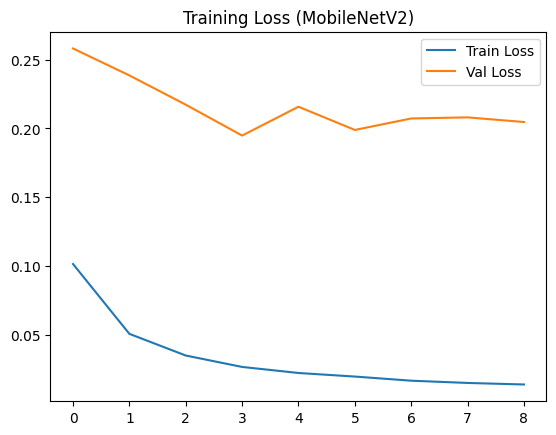

In [22]:
# Evaluation
def compute_accuracy(y_true, y_pred, threshold=0.5):
    pred_labels = (y_pred < threshold).astype(int)
    return np.mean(pred_labels == y_true)

print("Predicting on Test Set...")
predictions = model.predict(test_ds)
accuracy = compute_accuracy(te_y, predictions.ravel(), threshold=0.5)
print(f"Test Accuracy (Threshold=0.5): {accuracy * 100:.2f}%")

# Plot History
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training Loss (MobileNetV2)')
plt.legend()
plt.show()

C:\Users\OMEN\AppData\Local\Temp\ipykernel_11160\1468235671.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dist = float(batch_preds[i])


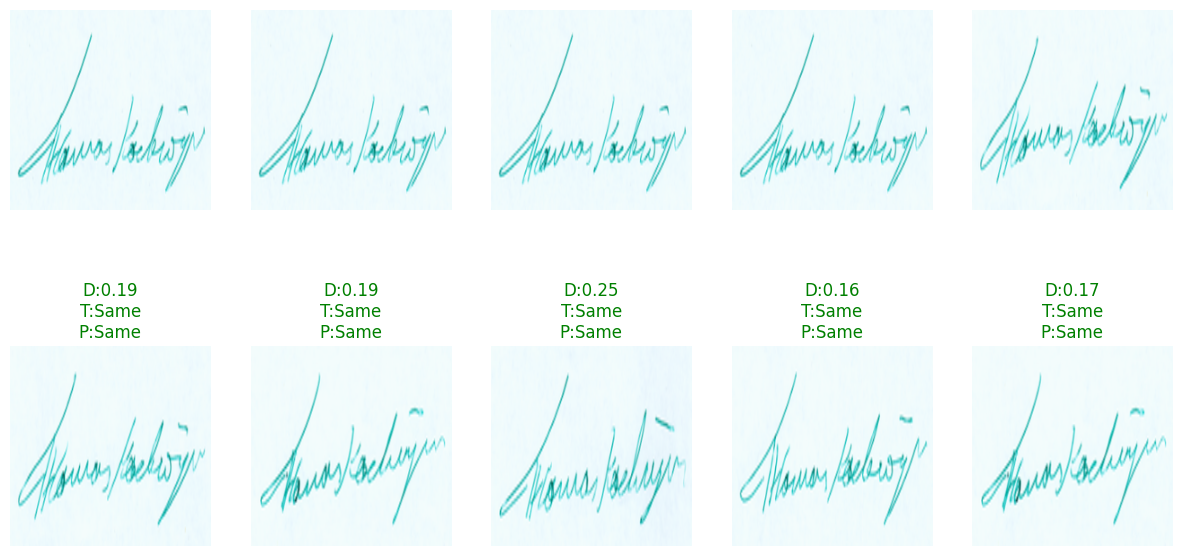

In [24]:
# Visualizing Results
def show_results(dataset, predictions, num_pairs=5):
    (img1_b, img2_b), label_b = next(iter(dataset))
    # Denormalize images for display ([-1, 1] -> [0, 1])
    img1_b = (img1_b + 1) / 2.0
    img2_b = (img2_b + 1) / 2.0
    
    batch_preds = predictions[:len(label_b)]
    
    plt.figure(figsize=(15, 8))
    for i in range(num_pairs):
        ax = plt.subplot(2, num_pairs, i + 1)
        plt.imshow(img1_b[i])
        plt.axis("off")
        
        ax = plt.subplot(2, num_pairs, i + 1 + num_pairs)
        plt.imshow(img2_b[i])
        
        dist = float(batch_preds[i])

        true_lbl = "Same" if label_b[i]==1 else "Diff"
        pred_lbl = "Same" if dist < 0.5 else "Diff"
        
        color = "green" if true_lbl == pred_lbl else "red"
        plt.title(f"D:{dist:.2f}\nT:{true_lbl}\nP:{pred_lbl}", color=color)
        plt.axis("off")
    plt.show()

show_results(test_ds, predictions)